In [4]:
from pdb import set_trace as debugger
from tqdm import tqdm
from math import sqrt
import numpy as np
import pandas
    
def upload_cifar(filename):
    import cPickle
    fo = open(filename, 'rb')
    data = cPickle.load(fo)
    fo.close()

    features = data['data']
    labels = data['labels']
    labels = np.atleast_2d( labels ).T 
    
    # squash classes 0-4 into class 0, and squash classes 5-9 into class 1
    labels[ labels < 5 ] = 0 
    labels[ labels >= 5 ] = 1 
    return features, labels

def upload_iris(filename):
    data = pandas.read_csv(filename)
    m = data.as_matrix()
    labels = m[:,0]
    labels[ labels==2 ] = 1  # squash class 2 into class 1
    labels = np.atleast_2d( labels ).T 
    features = m[:,1:5]
    return features, labels

### Perceptron class; it mainly trains the weights for us to use later
class Perceptron:
    
    def __init__(self, features, labels, test_features=None, test_labels=None, c = 1, theta = 0):
        # Set learning rate and theta
        self.c = c
        self.theta = theta
        # Add a bias feature into every instance
        self.features = np.insert(features, features.shape[1], 1, axis=1)
        self.labels = labels
        # Figure out test data
        if test_features is None and test_labels is None:
            # If no test input is provided, treat the training data as test data
            self.test_features = self.features
            self.test_labels = self.labels
        else:
            # Otherwise add bias feature into provided test input
            self.test_features = np.insert(test_features, test_features.shape[1], 1, axis=1)
            self.test_labels = test_labels
        # Create a (1,n+1) matrix of weights, +1 for bias input
        self._w = np.matrix(np.random.rand(features.shape[1] + 1))
        # Prediction accuracy per epoch
        self.pred_accuracy = [self.predict()]
        # L2 norm change list
        self.l2_change = [sqrt(self._w.dot(self._w.T).item())]
        
    def train(self):
        for _ in tqdm(xrange(100)):
            for instance, label in zip(self.features, self.labels):
                # Get our prediction 
                z_pred = int(self._w.dot(instance).item() > self.theta)
                # Compare to label and adjust weights if necessary
                lbl = label.item()
                if lbl != z_pred: 
                    self._adjust_weights(lbl - z_pred, instance)
            # Compute and save the L2 norm for an epoch
            self.l2_change.append(sqrt(self._w.dot(self._w.T).item()))
            # Generate a prediction with a current weight matrix
            self.pred_accuracy.append(self.predict())

    def _adjust_weights(self, learning_direction, instance):
        weight_changes = np.multiply(instance, (self.c * learning_direction))
        self._w = np.add(self._w, weight_changes)
        
    # Makes prediction on a test data and returns current accuracy
    def predict(self):
        corr = 0
        for instance, label in zip(self.test_features, self.test_labels):
            z_pred = int(self._w.dot(instance).item() > self.theta)
            if label.item() == z_pred: 
                corr += 1
        return float(corr) / float(self.test_features.shape[0])

In [20]:
### Plotting functions ###
import matplotlib.pyplot as plt
from math import log

def plot_accuracy(dataset_name, models):
    x = range(0,101)
    legend = list()
    # Plot the lines and build the legend
    for model in models:
        plt.plot(x, model.pred_accuracy)
        legend.append("c={}".format(model.learning_rate))
    # Prettify plot
    plt.xlim(xmin=0)    
    plt.ylim(ymin=min(model.pred_accuracy) - 0.01, ymax=max(model.pred_accuracy) + 0.01)
    plt.title("Dataset: {}".format(dataset_name))
    plt.xlabel("Epoch")
    plt.ylabel("Classification Accuracy")
    plt.legend(legend, loc="upper right", fontsize=8)
    # Show plot
    plt.show()

def plot_l2_norm(dataset_name, models):
    x = range(0,101)
    legend = list()
    # Plot the lines and build the legend
    for model in models:
        plt.plot(x, map(lambda x: log(x, 2), model.l2_change))
        legend.append("c={}".format(model.learning_rate))
    # Prettify plot    
    plt.xlim(xmin=0)    
    plt.ylim(ymin=0)
    plt.title("Dataset: {}".format(dataset_name))
    plt.xlabel("Epoch")
    plt.ylabel("Log of L2 norm of weights")
    plt.legend(legend, loc="upper right", fontsize=8)
    # Show plot
    plt.show()

In [6]:
# Namedtuple to hold perceptron data for us to plot later
from collections import namedtuple
ntuple = namedtuple("Perceptron", ['learning_rate', 'weights', 'l2_change', 'pred_accuracy'])

In [7]:
#### Run perceptron on IRIS dataset #####
iris_models = list()
features, labels = upload_iris("Fisher.csv")
for l_rate in [1, 0.1, 0.01]:
    # Run perceptron
    prcp = Perceptron(features, labels, c=l_rate)
    prcp.train()
    # Save the model data to plot later
    iris_models.append(ntuple(l_rate, prcp._w, prcp.l2_change, prcp.pred_accuracy))

100%|██████████| 100/100 [00:00<00:00, 168.38it/s]


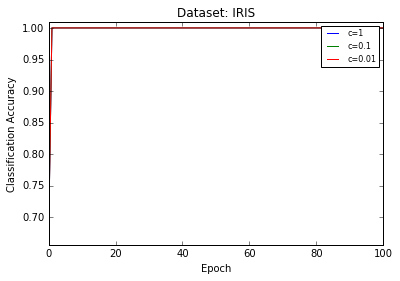

In [24]:
%matplotlib inline
### Plot IRIS model data: Accuracy ###
plot_accuracy('IRIS', iris_models)

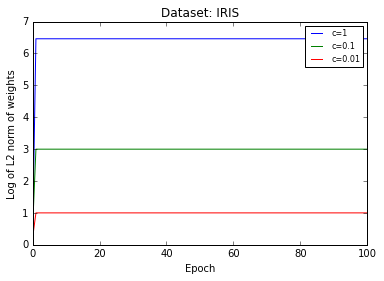

In [25]:
%matplotlib inline
### Plot IRIS model data: L2 norm ###
plot_l2_norm('IRIS', iris_models)

In [10]:
#### Run perceptron on CIFAR-10 dataset #####

import os
from collections import defaultdict

cifar_models = defaultdict(list)
BASE_DIR = 'cifar-10-batches-py'

for f_name in filter(lambda x: 'data' in x, os.listdir(BASE_DIR)):
    # Get relative path to file
    f_path = os.path.join(BASE_DIR, f_name)
    features, labels = upload_cifar(f_path)
    # Get the test features and labels from the test batch
    test_f, test_l = upload_cifar('cifar-10-batches-py/test_batch')
    # Train with different learning rates
    for l_rate in [0.001, 0.00001]:
        prcp = Perceptron(features, labels, test_features=test_f, test_labels=test_l, c=l_rate)
        prcp.train()
        # Save the model data to plot later
        cifar_models[f_path].append(ntuple(l_rate, prcp._w, prcp.l2_change, prcp.pred_accuracy))


100%|██████████| 100/100 [01:08<00:00,  1.47it/s]


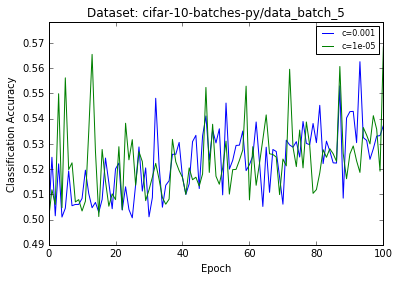

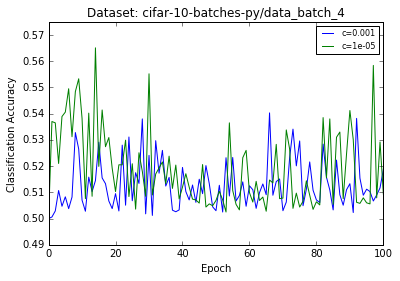

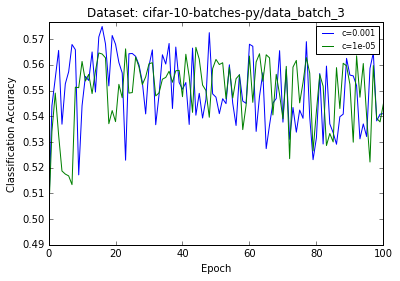

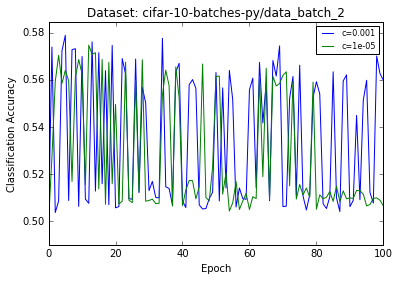

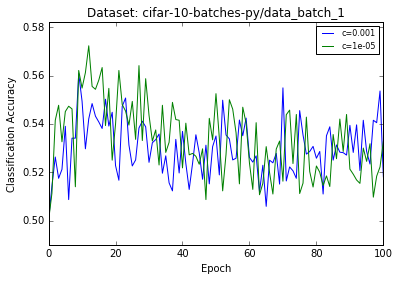

In [21]:
%matplotlib inline
### Plot CIFAR-10 model data: Accuracy ###
for f_path, models in cifar_models.iteritems():
    plot_accuracy(f_path, models)

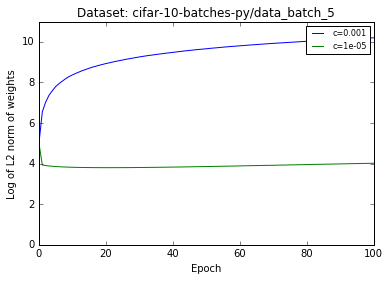

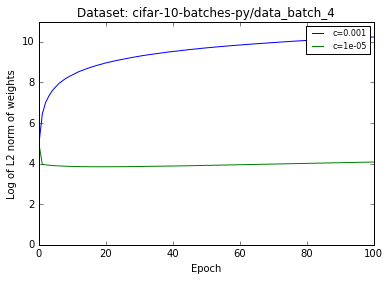

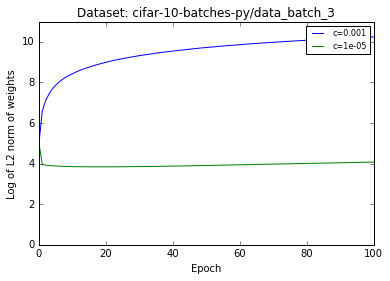

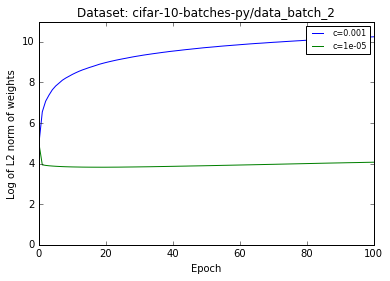

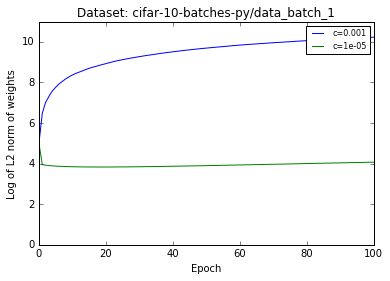

In [22]:
%matplotlib inline
### Plot CIFAR-10 model data: L2 norm ###
for f_path, models in cifar_models.iteritems():
    plot_l2_norm(f_path, models)